In [100]:
# visualising the result of applying filters
# to input
# i.e. visualising feature maps
# tutorial: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [307]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import skimage.io, scipy.ndimage, scipy.interpolate, scipy.signal, scipy.io.wavfile
import skimage.morphology, skimage.transform, skimage.feature, scipy.stats

%matplotlib inline
import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (18.0, 10.0)

#standard utilities
def show_image(img, title="untitled", cmap="gray", **kwargs):
    plt.figure()
    plt.imshow(img, cmap=cmap, interpolation="nearest", **kwargs)
    plt.axis("off")
    plt.title(title)
    
def apply_color(img, fn):
    return np.dstack((fn(img[:,:,0]),fn(img[:,:,1]),fn(img[:,:,2])))

def load_and_normalise(fname):
    return skimage.io.imread(fname) / 256.0

def load_gray(f):
    return skimage.color.rgb2gray(load_and_normalise(f))

In [205]:
# resize images
# read images into arrays
# read resized images back into folder for future use

import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image

folder = '/Users/Leonore/Documents/Workspace/l4proj/data/raw'

filenames = [os.path.join(folder, f)for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

image_width = 200
image_height = 200

dataset = np.ndarray(shape=(len(filenames), image_width, image_height), dtype=np.float32)

i = 0
for file in filenames:
    try:
        image = load_and_normalise(file)
        image_resized = resize(image, (image_width, image_height), anti_aliasing=False)
        dataset[i] = image_resized
    except Exception as e:
        print(e)
        print("{} is causing issues".format(file))
    i += 1

Could not find a format to read the specified file in mode 'i'
/Users/Leonore/Documents/Workspace/l4proj/data/raw/.DS_Store is causing issues


In [206]:
from sklearn.model_selection import train_test_split

# splitting and discarding labels as we don't need them
x_train, x_test, _, _ = train_test_split(dataset, dataset, test_size=0.2, random_state=11)

x_train = np.reshape(x_train, (len(x_train), image_width, image_height, 1))
x_test = np.reshape(x_test, (len(x_test), image_width, image_height, 1))

x_train.shape

(471, 200, 200, 1)

In [309]:
# build autoencoder for dataset

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(image_width, image_height, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((1, 1), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
filter_copy = x
x = MaxPooling2D((1, 1), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((1, 1), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((1, 1))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((1, 1))(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((1, 1))(x)

decoded = Conv2D(1, (3, 3), padding='same')(x)

In [310]:
model= Model(input_img, decoded)

In [315]:
sample = np.expand_dims(x_train[40], axis=0)

In [316]:
encoder = Model(inputs=input_img, outputs=encoded)

In [333]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = model.predict(x_test)

In [ ]:
fig = plt.figure(figsize=(28, 28))


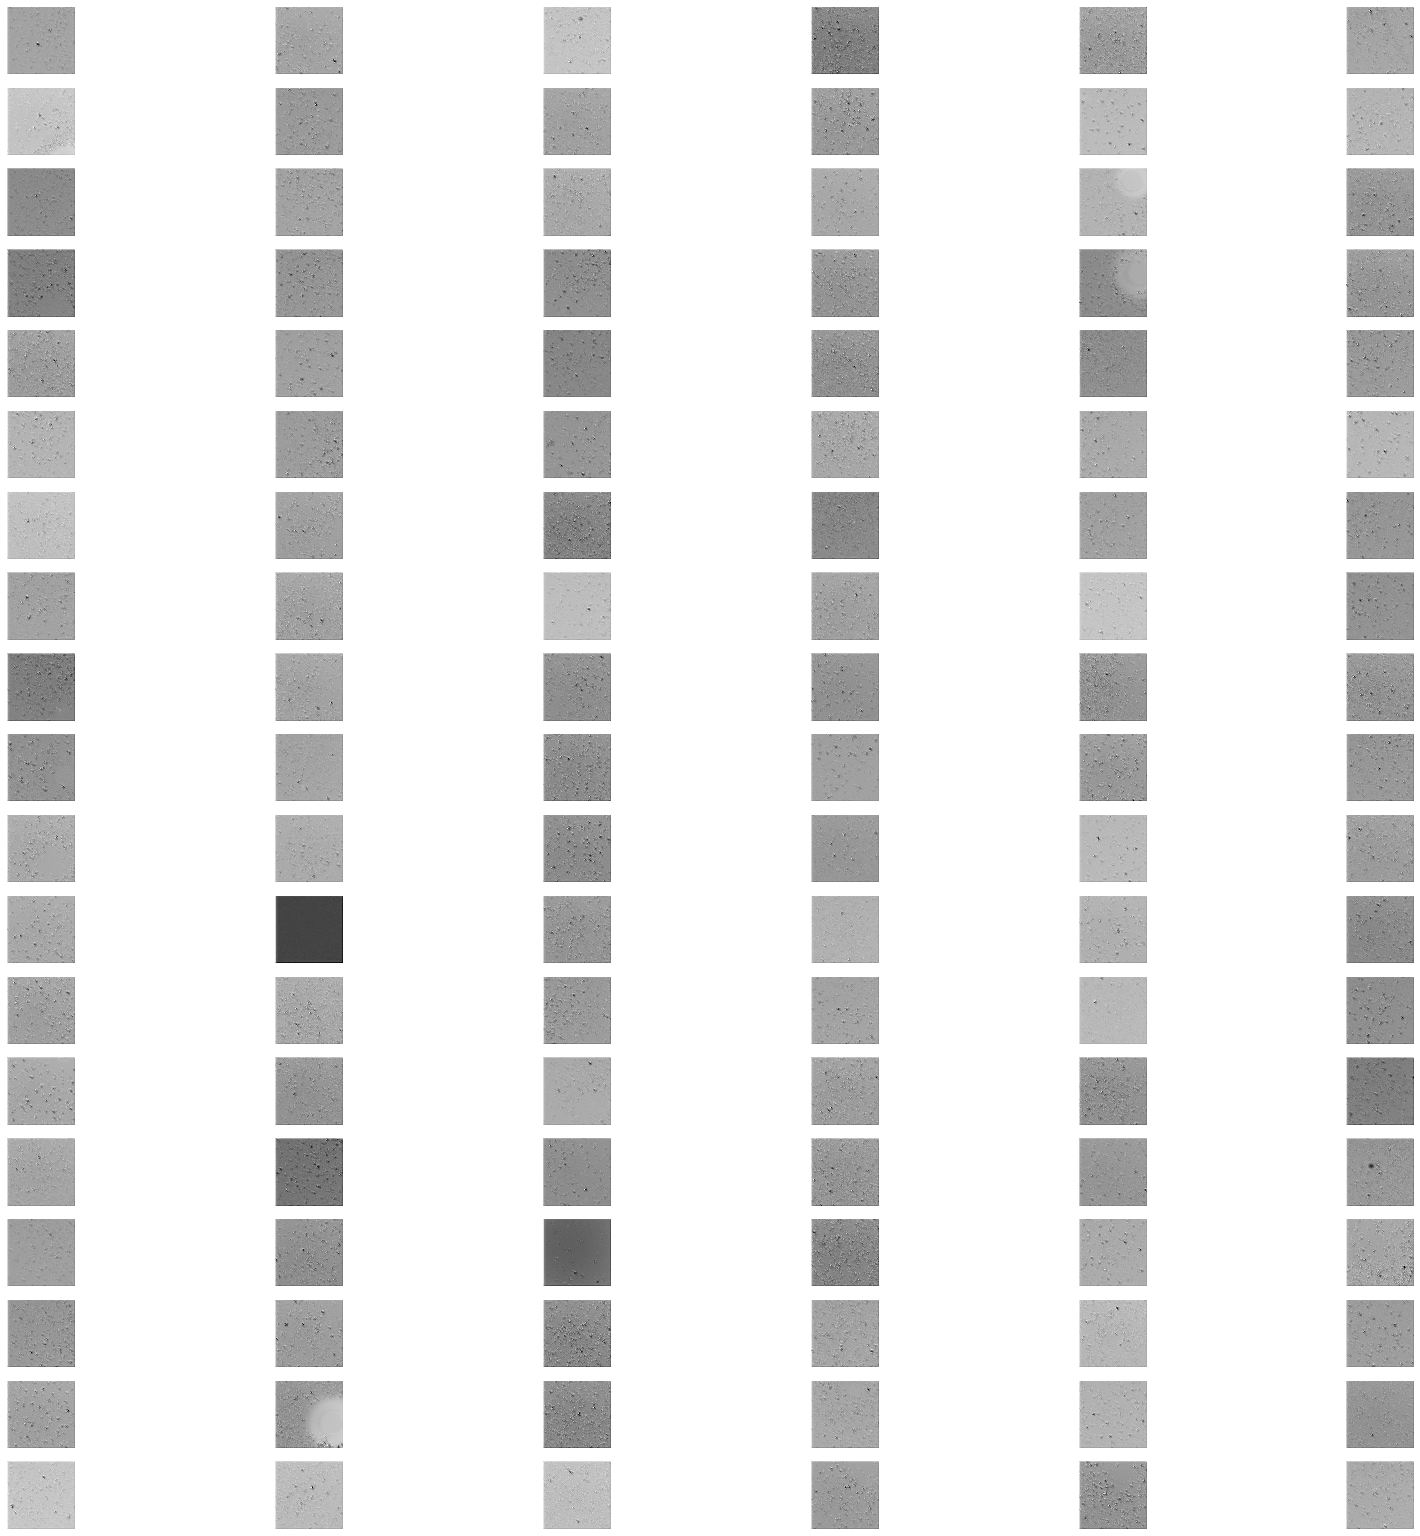

In [345]:
fig = plt.figure(figsize=(28, 28))

columns = 6
rows = len(x_test)//6
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    ax.axis("off")
    d1 = np.reshape(decoded_imgs[i], (image_width, image_height))
    plt.imshow(d1, cmap='gist_yarg')

plt.show()

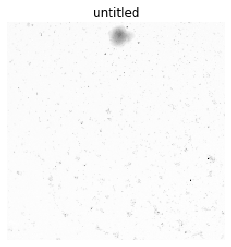

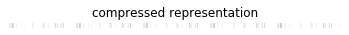

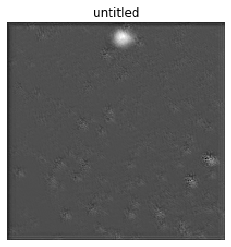

In [318]:
d1 = np.reshape(decoded_imgs[0], (image_width, image_height))
before = np.reshape(sample, (image_width, image_height))
show_image(before, cmap='gist_yarg')
show_image(np.reshape(encoded_imgs[0],(encoder.output.shape[1], encoder.output.shape[2]*encoder.output.shape[3])), "compressed representation", cmap="gist_yarg")
show_image(d1)

In [306]:
d1 = np.reshape(decoded_imgs[0], (image_width, image_height))
before = np.reshape(sample, (image_width, image_height))filters, biases = model.layers[1].get_weights()

SyntaxError: invalid syntax (<ipython-input-306-ee2ec7545743>, line 2)

In [236]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [237]:
n_filters, ix = 6, 1
for i in range(n_filters):
    f = filters[:,:,:,i]
    #plt.figure()
    #plt.imshow(f[:,:,0], cmap='gray')
    ix+=1

In [238]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

1 conv2d_113 (?, 200, 200, 64)
3 conv2d_114 (?, 200, 200, 32)
5 conv2d_115 (?, 200, 200, 16)
7 conv2d_116 (?, 200, 200, 16)
9 conv2d_117 (?, 200, 200, 32)
11 conv2d_118 (?, 200, 200, 64)
13 conv2d_119 (?, 200, 200, 1)


In [239]:
# redefine model to output right after the first hidden layer
feature_model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [240]:
x_train[12].shape

(200, 200, 1)

In [241]:
sample = np.expand_dims(x_train[44], axis=0)

In [242]:
sample.shape

(1, 200, 200, 1)

In [243]:
feature_maps = feature_model.predict(sample)

In [244]:
feature_maps.shape

(1, 200, 200, 64)

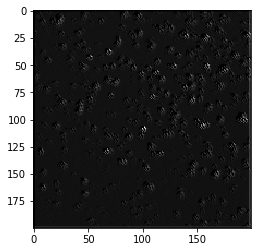

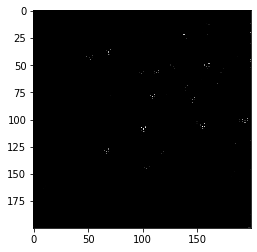

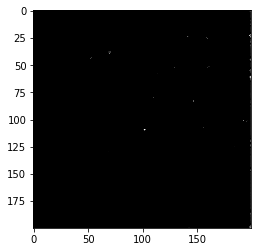

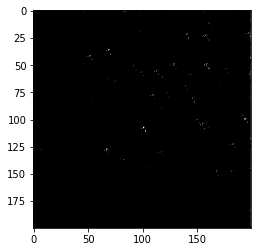

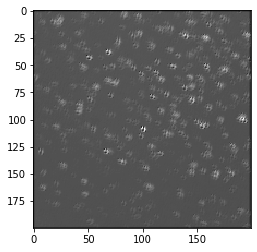

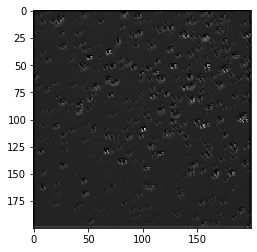

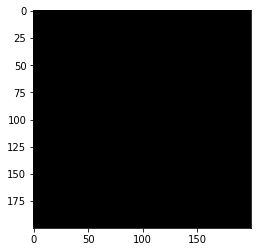

Error in callback <function flush_figures at 0x11f0b6f28> (for post_execute):


KeyboardInterrupt: 

In [245]:
square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        plt.figure()
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1

/Users/Leonore/Documents/Workspace/venv/ml/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  after removing the cwd from sys.path.


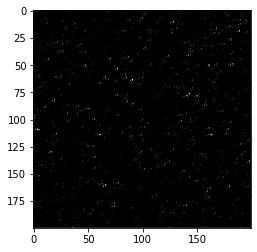

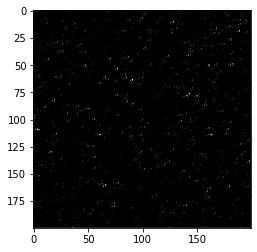

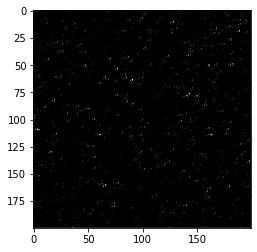

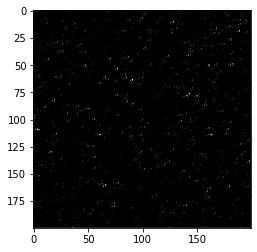

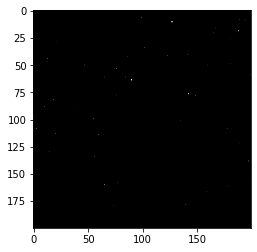

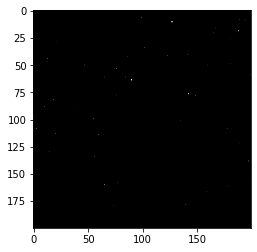

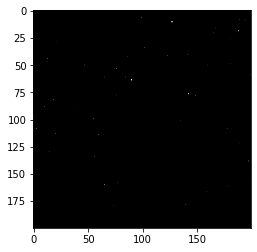

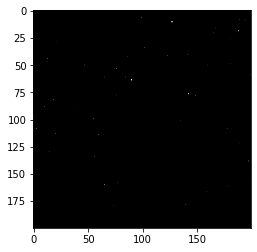

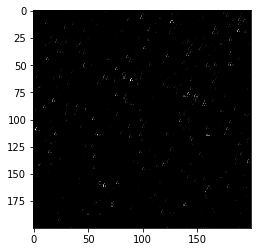

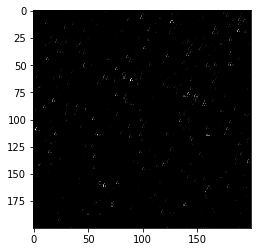

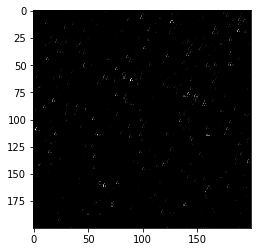

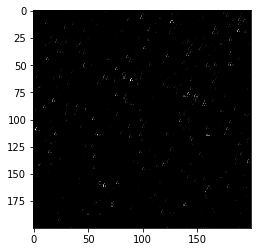

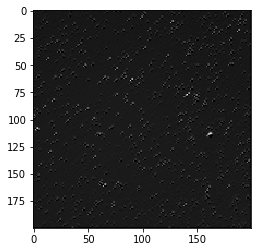

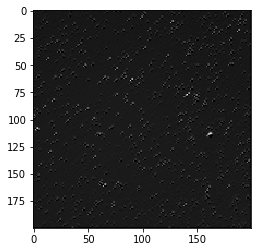

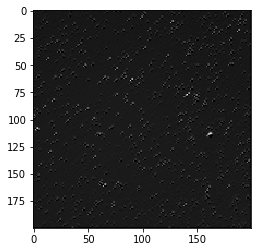

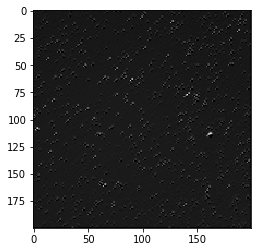

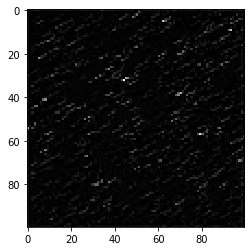

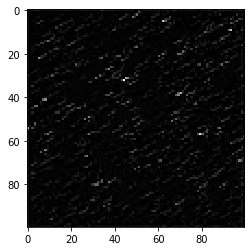

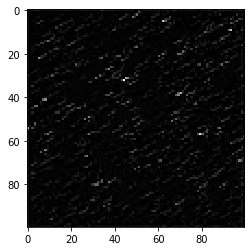

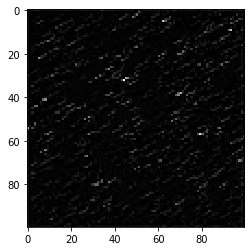

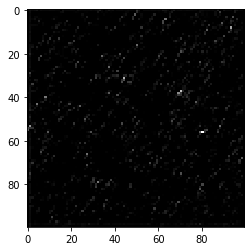

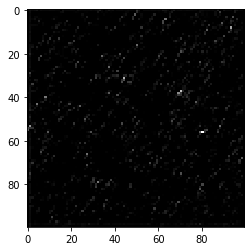

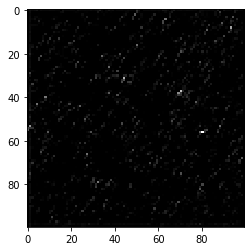

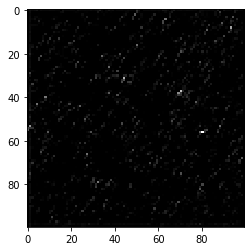

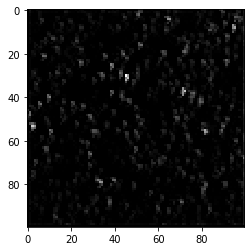

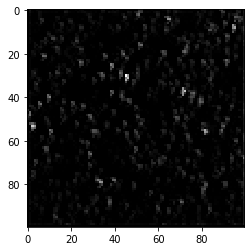

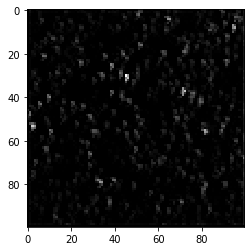

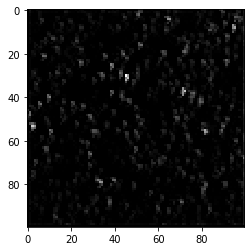

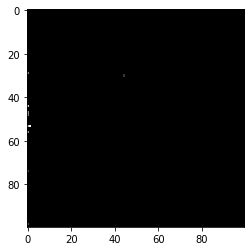

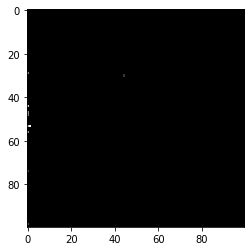

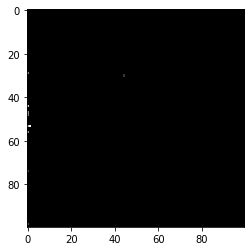

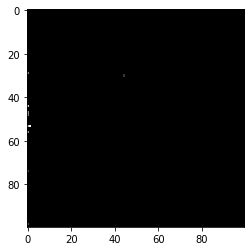

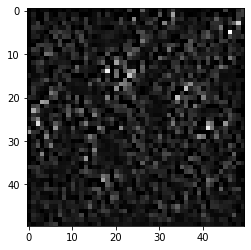

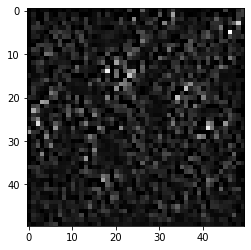

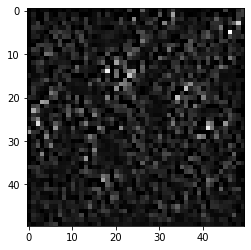

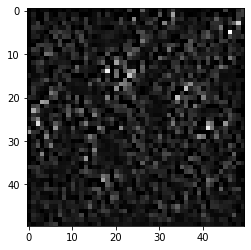

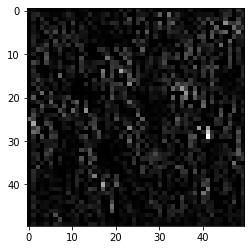

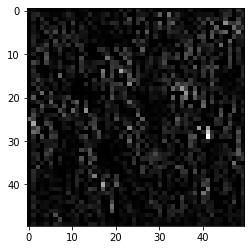

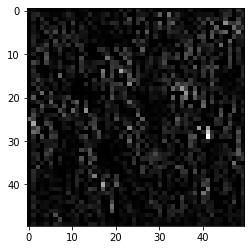

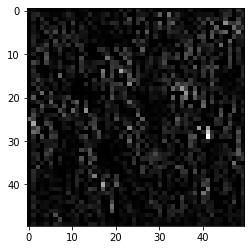

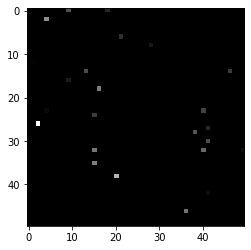

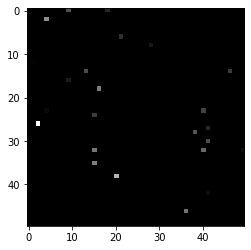

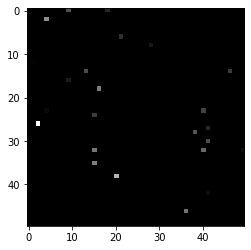

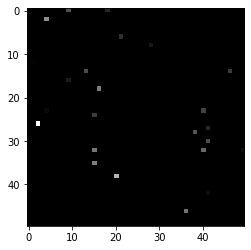

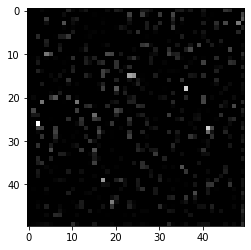

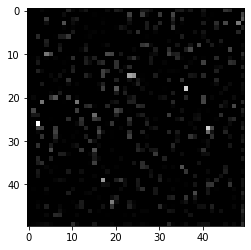

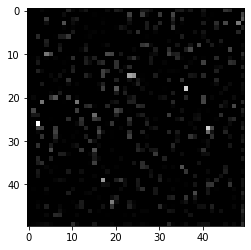

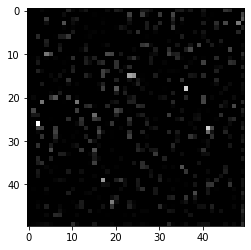

In [93]:
# plot the feature maps for each layer 
encoding_idx = [1, 3, 5]
outputs = [model.layers[i].output for i in encoding_idx]
feature_model = Model(inputs=model.inputs, output=outputs)
feature_maps = feature_model.predict(sample)
square = 4
for fmap in feature_maps:
    ix = 1
    for _ in range(square):
        for _ in range(square):
            plt.figure()
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
        ix += 1
    plt.show()

/Users/Leonore/Documents/Workspace/venv/ml/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


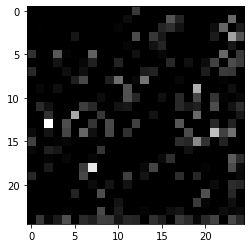

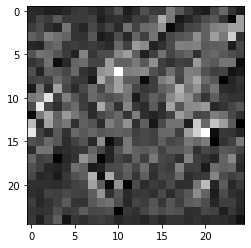

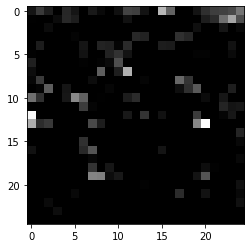

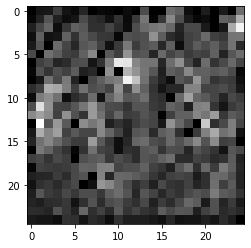

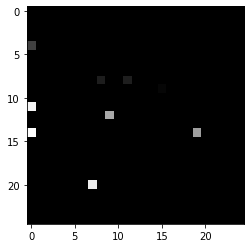

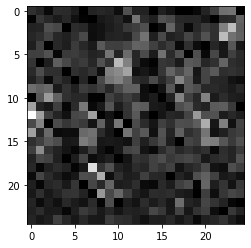

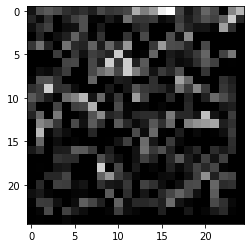

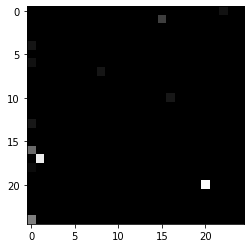

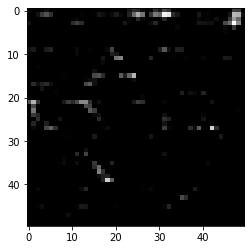

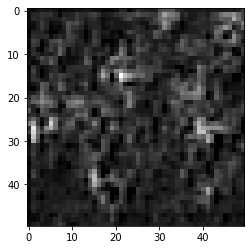

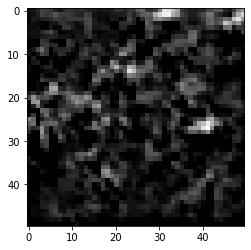

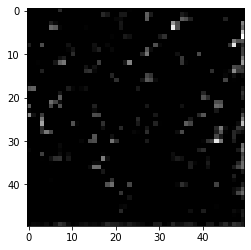

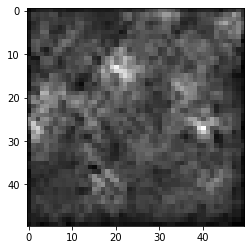

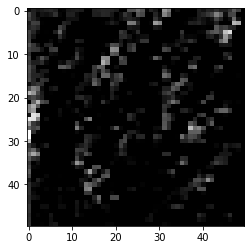

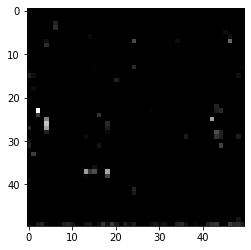

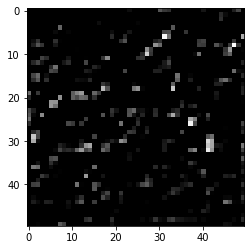

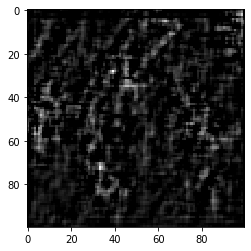

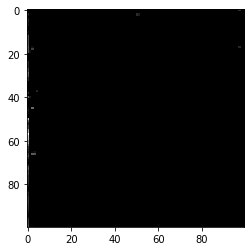

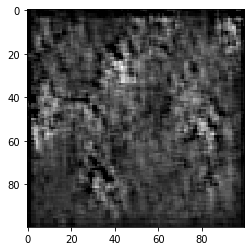

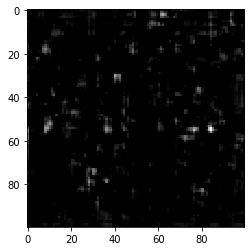

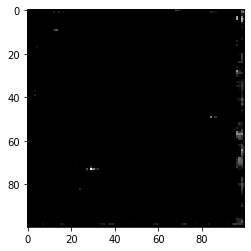

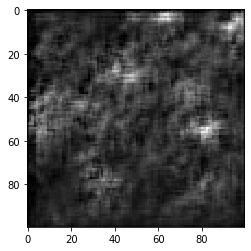

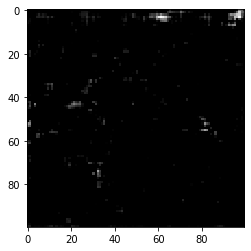

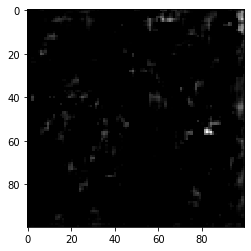

In [94]:
# plot the decompressed images from each layer
decoding_idx = [7, 9, 11]
outputs = [model.layers[i].output for i in decoding_idx]
decode_model = Model(inputs=model.inputs, outputs=outputs)
output_maps = decode_model.predict(sample)
square = 8
for out in output_maps:
    ix = 1
    for _ in range(square):
        plt.figure()
        plt.imshow(out[0, :, :, ix-1], cmap='gray')
        ix+=1